In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
power_df = pd.read_csv("../data/df_power_combined.csv")
# power_df
power_df.head()

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
0,2020-01-01 00:00,96211.0,65340.48,76500,30870.51,47.24561,26796.51,41.01058
1,2020-01-01 00:05,96211.0,65295.67,76500,30915.32,47.34665,26841.32,41.10734
2,2020-01-01 00:10,96211.0,65098.74,76500,31112.25,47.79241,27038.25,41.53422
3,2020-01-01 00:15,96211.0,64927.19,66000,31283.80,48.18289,27209.80,41.90817
4,2020-01-01 00:20,96211.0,64480.83,66000,31730.16,49.20868,27656.16,42.89052


In [3]:
# 시간대별로 sum

power_df['기준일시'] = power_df['기준일시'].str[0:13]
power_df_hour = power_df.groupby('기준일시').sum()
power_df_hour = power_df_hour.reset_index()
power_df_hour['기준일시'] = pd.to_datetime(power_df_hour['기준일시'], format='%Y-%m-%d %H')
power_df_hour

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
0,2020-01-01 00:00:00,1154532.00,770257.58,823500,384274.30,598.98289,335386.30,522.80598
1,2020-01-01 01:00:00,1154532.00,740066.45,792000,414465.43,672.30249,365577.43,593.02090
2,2020-01-01 02:00:00,1154653.00,715046.94,786800,439605.94,737.89210,387062.94,649.64256
3,2020-01-01 03:00:00,1155984.00,699127.26,776400,456856.62,784.21271,364108.62,625.01346
4,2020-01-01 04:00:00,1155984.00,698720.36,776400,457263.52,785.32759,364515.52,626.03893
...,...,...,...,...,...,...,...,...
26299,2022-12-31 19:00:00,1209671.21,809431.51,816000,400213.12,593.31613,173902.39,257.79664
26300,2022-12-31 20:00:00,1211901.03,800652.46,816000,411222.61,616.33833,155491.64,233.02491
26301,2022-12-31 21:00:00,1211180.94,791575.88,816000,419578.90,636.06437,140911.54,213.59484
26302,2022-12-31 22:00:00,1209057.62,788725.60,816000,420305.17,639.45436,129394.93,196.86263


In [4]:
# '기준일시' 열에서 년-월-일 형식의 'date' 열을 생성

power_df_hour['date'] = power_df_hour['기준일시'].dt.strftime('%Y-%m-%d')
power_df_hour['date'] = pd.to_datetime(power_df_hour['date'])

In [5]:
# 일별로 수요량 sum -> 일일 총 수요량

power_df_day = pd.pivot_table(data = power_df_hour, index = 'date', values = '현재수요(MW)', aggfunc = 'sum')
power_df_day

,현재수요(MW)
date,
2020-01-01,17097962.23
2020-01-02,19834469.20
2020-01-03,20211837.42
2020-01-04,18250125.91
2020-01-05,17060913.95
...,...
2022-12-27,22709272.51
2022-12-28,22524986.32
2022-12-29,22265836.25


## 시계열 분석

- 시계열 데이터 = Trend + Seasonal + Error 로 구성

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

In [7]:
# '기준일시' 열을 인덱스로 설정

ts = power_df_day
ts.head()

,현재수요(MW)
date,
2020-01-01,17097962.23
2020-01-02,19834469.20
2020-01-03,20211837.42
2020-01-04,18250125.91
2020-01-05,17060913.95


In [8]:
ts.tail()

,현재수요(MW)
date,
2022-12-27,22709272.51
2022-12-28,22524986.32
2022-12-29,22265836.25
2022-12-30,21214977.83
2022-12-31,18558640.59


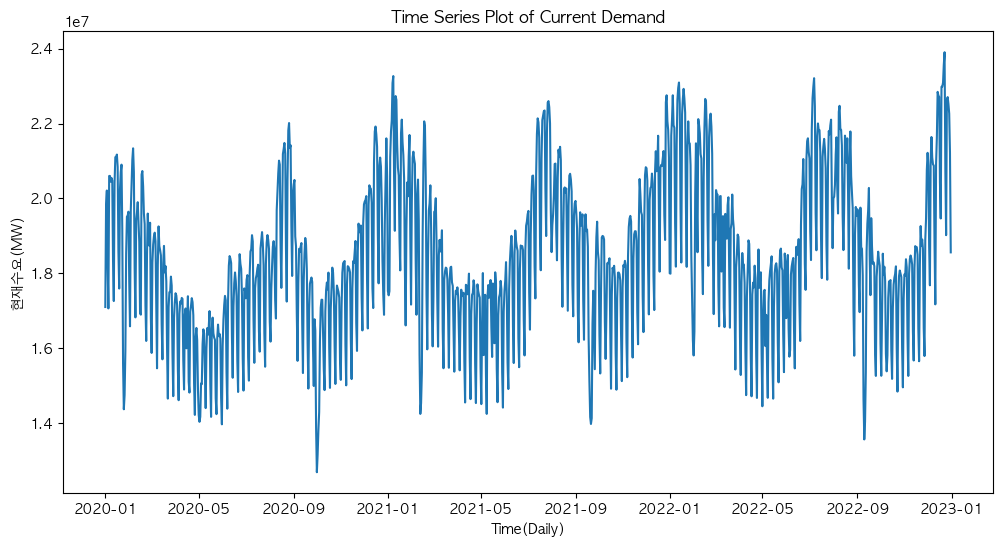

In [9]:
# 시계열 데이터 시각화

plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Time Series Plot of Current Demand')
plt.xlabel('Date')
plt.ylabel('현재수요(MW)')
plt.show()

In [10]:
# plt 확장

from pylab import rcParams
rcParams['figure.figsize']=15,10

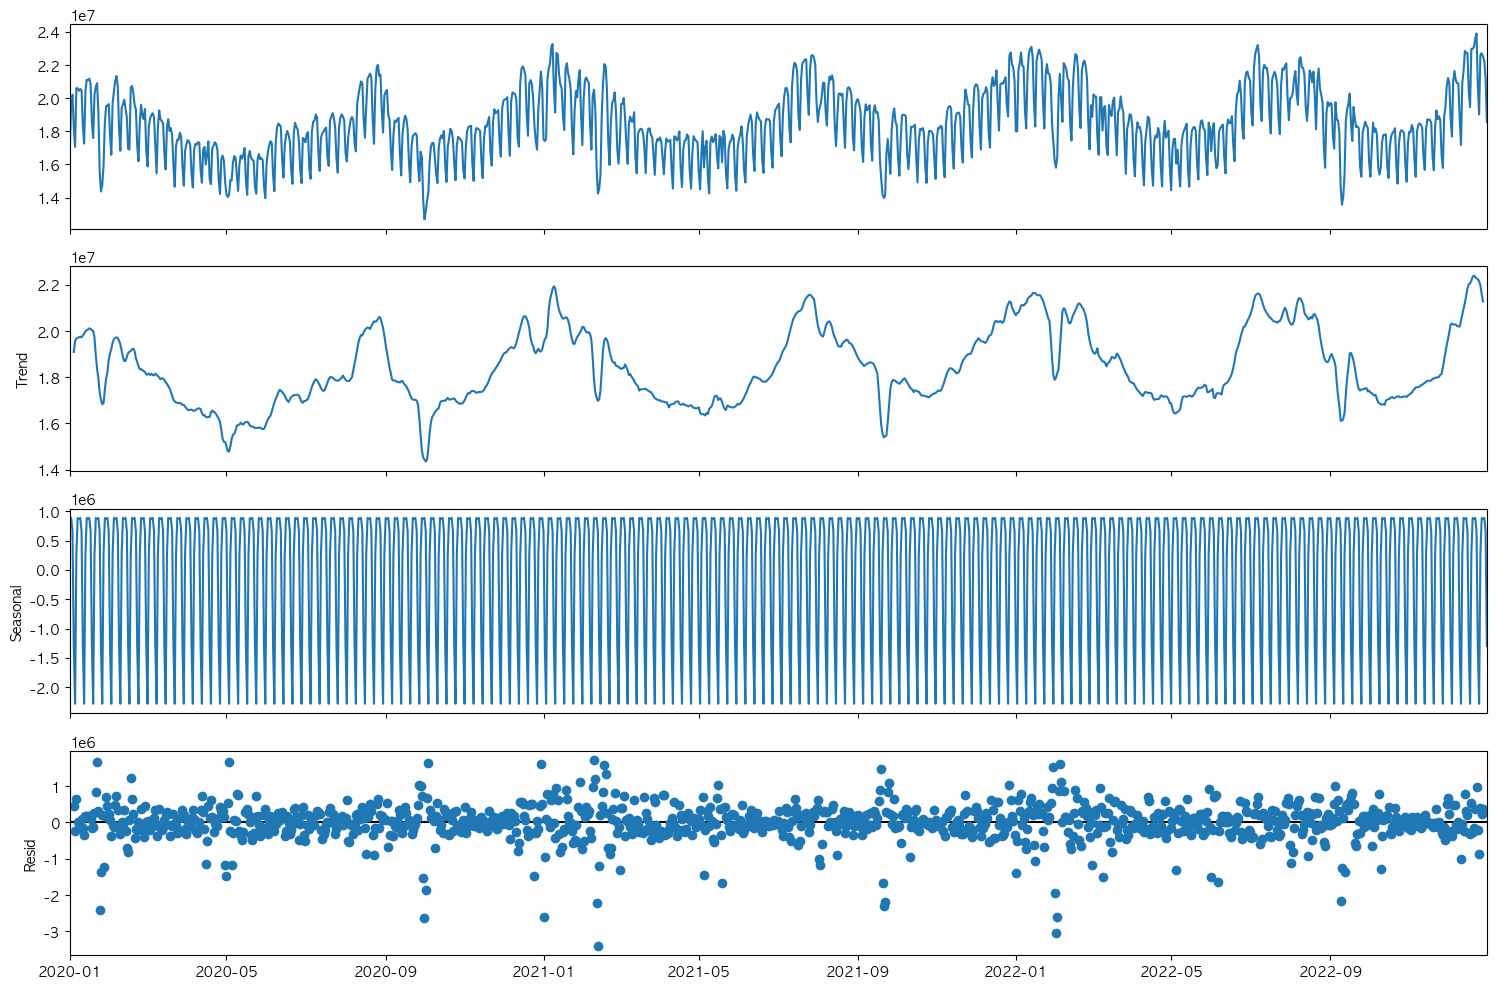

In [11]:
# 시계열 분해 (Time Series Decomposition)

result = seasonal_decompose(ts, model='additive')
result.plot()
plt.show()

- Observed (관측값): 원본 데이터인 '현재수요(MW)' 열
- Trend (추세): 데이터의 장기적인 변동을 보여주는 부분으로, 시계열 데이터가 시간에 따라 증가하거나 감소하는 경향을 보일 때
- Seasonal (계절성): 주기적으로 반복되는 패턴을 보여주는 부분
- Residual (잔차): 추세와 계절성을 제외한 나머지 부분으로, 모델이 설명하지 못하는 남은 변동

## 정상성 검정

- 정상 시계열은 시간의 흐름에 따라 그 통계적 특성이 변하지 않는 시계열을 의미함
- 정상 시계열의 평균과 분산(표준편차), 공분산은 시간이 변해도 일정함
- 많은 통계적 시계열 모델들(AR, MA, ARMA, ARIMA 등)은 데이터의 정상성을 가정하고 있음

대부분의 실제 시계열 데이터는 비정상적인 성질을 가지고 있고, 이 경우에는 데이터를 정상적으로 만드는 변환(차분, 로그 변환 등)이 필요할 수 있음

- 비정상 시계열의 경우 대부분 추세가 있거나, 계절성이 있거나, 분산에 변동이 있음
- 그 말은 즉 추세를 제거하거나(detrending) 계절성을 제거하거나(deseasoning), 분산을 일정하게 만들면 그 시계열은 정상성을 띠게 된다는 것임

추세와 계절성을 제거하기 위한 방법으로는 대표적으로 세가지 방법이 있음.

1. 회귀 분석(regression approach)
2. 평활법(smoothing)
3. 차분(differencing): 데이터들의 차이를 구하는 것

## 1. Kwiatkowski-Phillips-Schmidt-Shin(KPSS) 검정

95% 신뢰도를 바탕으로 0.05 유의수준을 두면

- H0: 해당 시계열은 정상 시계열이다.
- H1: 해당 시계열은 비정상 시계열이다.
    - p-value <= 0.05: H0 기각/ H1 채택 -> 비정상 시계열
    - p-value > 0.05: H0 채택/ H1 기각 -> 정상 시계열

In [12]:
# 1. KPSS 검정

kpss_test_result = kpss(ts)

print(f'KPSS Statistic: {kpss_test_result[0]}')
print(f'p-value: {kpss_test_result[1]}')
print(f'Lags Used: {kpss_test_result[2]}')
print(f'Critical Values: {kpss_test_result[3]}')

print(f'검증결과: {"비정상(non-stationary)" if kpss_test_result[1] <= 0.05 else "정상(stationary)"} 시계열 데이터입니다.')

KPSS Statistic: 0.7430466391108305
p-value: 0.01
Lags Used: 16
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


/var/folders/pl/c1z33rhx0tz096sc8p4_flzw0000gn/T/ipykernel_15876/2197487823.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_result = kpss(ts)


## 2. Augmented Dickey-Fuller(ADF) 검정 - 단위근 검정

95% 신뢰도를 바탕으로 0.05 유의수준을 두면 

**주의: kpss test와 귀무가설이 반대**
- H0: 해당 시계열은 비정상 시계열이다. (시계열에 단위근이 존재한다.)
- H1: 해당 시계열은 정상 시계열이다.
    - p-value <= 0.05: H0 기각/ H1 채택 -> 정상 시계열
    - p-value > 0.05: H0 채택/ H1 기각 -> 비정상 시계열

In [13]:
# 2. ADF 검정

adf_test_result = adfuller(ts, autolag='AIC')

print(f'ADF Statistic: {adf_test_result[0]}')
print(f'p-value: {adf_test_result[1]}')
print(f'Critical Values: {adf_test_result[4]}')
print(f'Best number of lags (AIC): {adf_test_result[3]}')

# 검증 결과 출력
print(f'검증결과: {"정상(stationary)" if adf_test_result[1] <= 0.05 else "비정상(non-stationary)"} 시계열 데이터입니다.')

# 5% 유의수준이면 정상, 1% 유의수준이면 비정상

ADF Statistic: -3.3802295339986768
p-value: 0.011651595050739783
Critical Values: {'1%': -3.436459052172655, '5%': -2.864237372528562, '10%': -2.568206176974609}
Best number of lags (AIC): 1073
검증결과: 정상(stationary) 시계열 데이터입니다.


### 정상성 확보를 위한 차분

In [14]:
# 1차 차분

ts_diff = ts.diff().dropna()
# 차분을 진행할 때는 두 값을 빼주게 됨. 그렇기에 차분을 진행할 때마다 데이터의 길이가 짧이지면서, 짧아진 부분에 공백이 생김.
# 이 공백을 지워주지 않으면 ADF검정 과정에서 오류가 발생할 수 있다고 함.

In [15]:
# 1. 1차 차분 후 KPSS 검정

kpss_test_result_diff = kpss(ts_diff)

print(f'KPSS Statistic after differencing: {kpss_test_result_diff[0]}')
print(f'p-value after differencing: {kpss_test_result_diff[1]}')
print(f'Lags Used after differencing: {kpss_test_result_diff[2]}')
print(f'Critical Values after differencing: {kpss_test_result_diff[3]}')

print(f'검증결과: {"비정상(non-stationary)" if kpss_test_result_diff[1] <= 0.05 else "정상(stationary)"} 시계열 데이터입니다.')

KPSS Statistic after differencing: 0.036706817180015706
p-value after differencing: 0.1
Lags Used after differencing: 89
Critical Values after differencing: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
검증결과: 정상(stationary) 시계열 데이터입니다.


/var/folders/pl/c1z33rhx0tz096sc8p4_flzw0000gn/T/ipykernel_15876/4077214608.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_result_diff = kpss(ts_diff)


In [16]:
# 2. 1차 차분 후 ADF 검정

adf_test_result_diff = adfuller(ts_diff, autolag='AIC')

print(f'ADF Statistic: {adf_test_result_diff[0]}')
print(f'p-value: {adf_test_result_diff[1]}')
print(f'Critical Values: {adf_test_result_diff[4]}')
print(f'Best number of lags (AIC): {adf_test_result_diff[3]}')

print(f'검증결과: {"정상(stationary)" if adf_test_result_diff[1] <= 0.05 else "비정상(non-stationary)"} 시계열 데이터입니다.')

ADF Statistic: -7.36492581928262
p-value: 9.29014868301968e-11
Critical Values: {'1%': -3.4364533503600962, '5%': -2.864234857527328, '10%': -2.568204837482531}
Best number of lags (AIC): 1074
검증결과: 정상(stationary) 시계열 데이터입니다.


## AutoRegressive Integrated Moving Average(ARIMA) 모델

- 'order' 매개변수는 ARIMA 모델의 차수를 지정함
- (p, d, q)로 구성
    - 각각 자기회귀(AR) 차수, 차분(Differencing) 차수, 이동평균(MA) 차수를 나타냄

### AIC (Akaike Information Criterion)
- AIC는 모델이 데이터에 얼마나 잘 맞는지를 측정하는 지표로서, 동시에 모델의 전체 복잡성을 고려함.
- 많은 특성을 사용하면서 데이터에 매우 잘 맞는 모델은, 동일한 적합성을 달성하는데 덜 많은 특성을 사용하는 모델보다 더 높은 AIC 점수를 얻게 됨. 따라서, 낮은 AIC 값을 갖는 모델을 찾는 것이 중요함.

- 간단히 말하면, AIC는 모델의 적합성과 복잡성 사이의 균형을 제공함. 모델이 데이터를 얼마나 잘 설명하는지에 대한 품질 측정과 함께, 모델이 사용하는 특성의 수를 고려하여 모델을 평가함. 따라서 AIC가 낮을수록 모델의 성능이 좋다고 판단할 수 있음.

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [18]:
# 데이터를 학습 데이터와 검증 데이터로 나누기
train_size = int(len(ts) * 0.8)
train, validation = ts[0:train_size], ts[train_size:]

# 가능한 매개변수 조합 생성
p_values = range(0, 2)
d_values = range(1, 2)  # 1차 차분 이상해야 정상성 확보
q_values = range(0, 2)

# 최적 매개변수 초기화
best_aic, best_cfg = float("inf"), None

# Grid Search를 통한 최적 매개변수 찾기
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # ARIMA 모델 생성 및 훈련
                model = ARIMA(train, order=order)
                fit_model = model.fit()

                # AIC 계산
                aic = fit_model.aic

                # 현재 조합의 성능이 더 좋으면 갱신
                if aic < best_aic:
                    best_aic, best_cfg = aic, order

            except Exception as e:
                print(f"An exception occurred during model training: {str(e)}")
                continue

# 최적 매개변수 출력
print(f"Best ARIMA Order (by AIC): {best_cfg}")
print(f"Best AIC: {best_aic}")

# 최적 매개변수로 ARIMA 모델 훈련 및 예측
best_model = ARIMA(ts, order=best_cfg)
best_fit_model = best_model.fit()

# 예측
predictions = best_fit_model.predict(start=len(train), end=len(ts) - 1, dynamic=False)

# 예측 결과와 실제 데이터 비교
# MSE, RMSE 계산
mse = mean_squared_error(validation, predictions)
rmse = np.sqrt(mse)

print(f'Mean Squared Error on Validation Data: {mse}')
print(f'Root Mean Squared Error on Validation Data: {rmse}')

# MAPE 계산
mape = mean_absolute_percentage_error(validation, predictions)

print(f'Mean Absolute Percentage Error on Validation Data: {mape:.4f}')

/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/choiseoyeo/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency i

Best ARIMA Order (by AIC): (1, 1, 1)
Best AIC: 27183.299496020853
Mean Squared Error on Validation Data: 1839853765927.0137
Root Mean Squared Error on Validation Data: 1356412.0929595893
Mean Absolute Percentage Error on Validation Data: 0.0518


In [26]:
# 예측 시작일과 종료일 설정
start_date = ts.index[-1] + pd.Timedelta(hours=1)
end_date = start_date + pd.Timedelta(days=10)

# ARIMA 모델을 사용하여 예측
predictions = best_fit_model.predict(start=start_date, end=end_date, dynamic=False)

print(predictions)

2023-01-01    1.766077e+07
2023-01-02    1.814404e+07
2023-01-03    1.788392e+07
2023-01-04    1.802393e+07
2023-01-05    1.794857e+07
2023-01-06    1.798913e+07
2023-01-07    1.796730e+07
2023-01-08    1.797905e+07
2023-01-09    1.797273e+07
2023-01-10    1.797613e+07
2023-01-11    1.797430e+07
Freq: D, Name: predicted_mean, dtype: float64


## 예측 결과 시각화

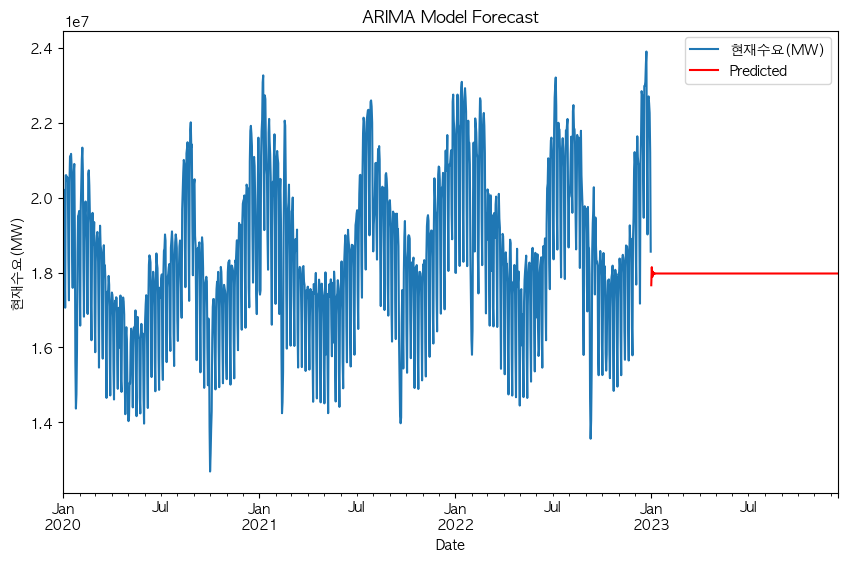

In [25]:
import matplotlib.pyplot as plt

# 기존 시계열 데이터
ts.plot(label='Observed', figsize=(10, 6))

# 예측 결과 시계열 데이터
predictions.plot(label='Predicted', color='red')

# 그래프 설정
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('현재수요(MW)')
plt.legend()
plt.show()